1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2023-12-03 16:21:42--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2023-12-03 16:21:42--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc22120ca991b207da707dbcaf86.dl.dropboxusercontent.com/cd/0/inline/CIvu2pEzcp1Gn6Ku8ji8kGNmXaQ8ystGyHWpc6d6JUrtKpEUsjPY3bPfFHyu5OyIIa6H0yzFTk-NJt4kIe0ixnFRSXJpHRBuM72vaqmXw5756ppl4uzxb1g7Ey_d3ioKqQ8/file# [following]
--2023-12-03 16:21:42--  https://uc22120ca991b207da707dbcaf86.dl.dropboxusercontent.com/cd/0/inline/CIvu2pEzcp1Gn6Ku8ji8kGNmXaQ8ystGyHWpc6d6JUrtKpEUsjPY3bPfFHyu5OyIIa6H0yzFTk-NJt4kIe0ixnFRSXJpHRBuM72vaqmXw5756ppl4u

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/data/data_000637.txt',nrows=10000)
df.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


In [ ]:
df.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,10000.0,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000
mean,1.0,0.298500,55.44760,3.869200e+09,1811.587300,13.377900
std,0.0,0.457623,39.41824,2.878264e+01,1064.248181,9.223817
min,1.0,0.000000,1.00000,3.869200e+09,0.000000,0.000000
25%,1.0,0.000000,24.00000,3.869200e+09,835.000000,5.000000
50%,1.0,0.000000,56.00000,3.869200e+09,1812.000000,13.000000
75%,1.0,1.000000,64.00000,3.869200e+09,2782.000000,21.000000
max,1.0,1.000000,139.00000,3.869200e+09,3563.000000,29.000000


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [ ]:
df['BX_num'] = df.groupby('ORBIT_CNT')['BX_COUNTER'].transform(np.max)
mean_BX = df['BX_num'].mean()
print("mean BX counter in each orbit :",mean_BX, '\n')
df

mean BX counter in each orbit : 3165.6349 



,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,BX_num
0,1,0,123,3869200167,2374,26,3187
1,1,0,124,3869200167,2374,27,3187
2,1,0,63,3869200167,2553,28,3187
3,1,0,64,3869200167,2558,19,3187
4,1,0,64,3869200167,2760,25,3187
...,...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11,777
9996,1,0,60,3869200267,701,5,777
9997,1,0,59,3869200267,707,23,777
9998,1,0,63,3869200267,706,15,777


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [ ]:
dfa = df.copy()

dfa['ABS_TIME'] = dfa['TDC_CHANNEL'] * 25/30 + dfa['BX_COUNTER'] * 25
dfa

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,BX_num,ABS_TIME
0,1,0,123,3869200167,2374,26,3187,59452.500000
1,1,0,124,3869200167,2374,27,3187,59453.333333
2,1,0,63,3869200167,2553,28,3187,63877.500000
3,1,0,64,3869200167,2558,19,3187,64003.333333
4,1,0,64,3869200167,2760,25,3187,69053.333333
...,...,...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11,777,17450.833333
9996,1,0,60,3869200267,701,5,777,17575.000000
9997,1,0,59,3869200267,707,23,777,17724.166667
9998,1,0,63,3869200267,706,15,777,17702.500000


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [ ]:
dfa["ABS_TIME_SECOND"]=pd.to_datetime(dfa["ABS_TIME"],unit='ns')
duration = dfa["ABS_TIME_SECOND"].max()-dfa["ABS_TIME_SECOND"].min()
print(duration)

durations = dfa.groupby('ORBIT_CNT').max()-dfa.groupby('ORBIT_CNT').min()
duration_for_all_orbits = durations['ABS_TIME_SECOND'].sum()
print('all data taking time: ',duration_for_all_orbits)

0 days 00:00:00.000089152
all data taking time:  0 days 00:00:00.007011503


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [ ]:
# dfa_noise = dfa.groupby('TDC_CHANNEL').transform(np.count_nonzero)
dfa['NOISE'] = dfa.groupby('TDC_CHANNEL')['ORBIT_CNT'].transform(np.count_nonzero).apply(np.max)
dfa.sort_values('NOISE',ascending=False).head(3)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,BX_num,ABS_TIME,ABS_TIME_SECOND,NOISE
8240,1,1,139,3869200249,2447,0,3529,61290.833333,1970-01-01 00:00:00.000061290,860
3965,1,0,139,3869200206,1746,0,1746,43765.833333,1970-01-01 00:00:00.000043765,860
3933,1,0,139,3869200206,1199,0,1746,30090.833333,1970-01-01 00:00:00.000030090,860


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [ ]:
count_of_orbits =np.count_nonzero( dfa['ORBIT_CNT'].unique())
print(count_of_orbits)

101


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [ ]:
dfa_non_empty=dfa.loc[dfa['TDC_CHANNEL'] == 139]
count_of_orbits =np.count_nonzero( dfa_non_empty['ORBIT_CNT'].unique())
print(count_of_orbits)

101


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [ ]:
df_fpga_0 = dfa.loc[dfa['FPGA'] == 0]
df_fpga_1 = dfa.loc[dfa['FPGA'] == 1]
series_fpga_0 = df_fpga_0['TDC_CHANNEL'].value_counts().sort_index()
series_fpga_1 = df_fpga_1['TDC_CHANNEL'].value_counts().sort_index()

print(series_fpga_0)
print(series_fpga_1)


1        4
2       10
3        8
4       11
5       11
      ... 
121     45
122     55
123    138
124    130
139    599
Name: TDC_CHANNEL, Length: 117, dtype: int64
1      237
2      250
3      193
4      200
5      128
      ... 
125      2
126      1
127     10
128     11
139    261
Name: TDC_CHANNEL, Length: 115, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

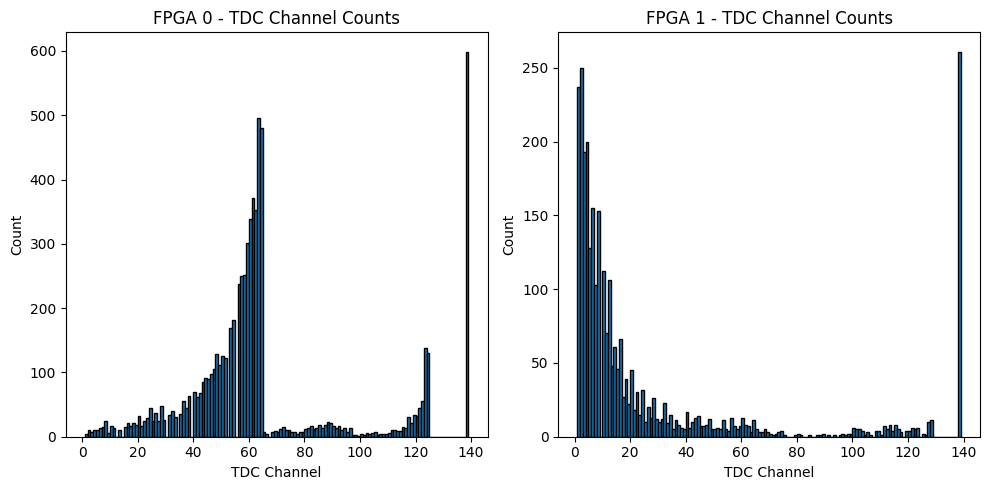

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df_fpga_0['TDC_CHANNEL'], bins=range(df_fpga_0['TDC_CHANNEL'].min(), df_fpga_0['TDC_CHANNEL'].max() + 1), edgecolor='black')
plt.title('FPGA 0 - TDC Channel Counts')
plt.xlabel('TDC Channel')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df_fpga_1['TDC_CHANNEL'], bins=range(df_fpga_1['TDC_CHANNEL'].min(), df_fpga_1['TDC_CHANNEL'].max() + 1), edgecolor='black')
plt.title('FPGA 1 - TDC Channel Counts')
plt.xlabel('TDC Channel')
plt.ylabel('Count')

plt.tight_layout()
plt.show()